In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn 
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor

import clip

## data visualization

In [4]:
import deeplake
from torchvision import transforms, models

ds_train = deeplake.load('hub://activeloop/pacs-train')
ds_test = deeplake.load('hub://activeloop/pacs-test')

batch_size = 8

tform = transforms.Compose([
    # transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.5], [0.5]),
])

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

In [5]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


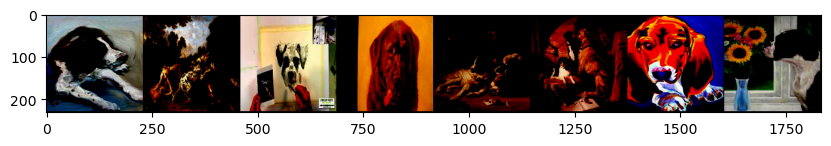

torch.Size([8, 3, 227, 227])


In [6]:
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images, nrow=8))
print(images.shape)

## load data

In [ ]:
import pickle

## load pickle
with open('class_tokens.pickle', 'wr') as fr:
    class_tokens = pickle.load(fr)
with open('class_features.pickle', 'wr') as fr:
    class_features = pickle.load(fr)
with open('train_image_features_list.pickle', 'rb') as fr:
    train_image_features_list = pickle.load(fr)
with open('train_labels_list.pickle', 'rb') as fr:
    train_labels_list = pickle.load(fr)
with open('test_image_features_list.pickle', 'rb') as fr:
    test_image_features_list = pickle.load(fr)
with open('test_labels_list.pickle', 'rb') as fr:
    test_labels_list = pickle.load(fr)

#### Model

In [7]:
# Define model
class OurCLIP(nn.Module):        
    def __init__(self, clip_model, # use pre-trained clip model
                 use_one_ln1=True, use_one_ln2=True, 
                 use_one_projection1=True, use_one_projection2=True,
                 projection_random_init1=False, 
                 projection_random_init2=False, 
                 trainable_ln1=False, trainable_ln2=False, 
                 trainable_projection1=False, trainable_projection2=False,
                 threshold = 100, score_type=0): 
        super().__init__()

        self.dtype = clip_model.dtype
        self.threshold = threshold
        self.score_type = score_type

        self.threshold_weight = nn.Parameter(torch.rand(1)).requires_grad_(True)

        ####################### 미구현
        if use_one_ln1:
            self.ln_post = clip_model.visual.ln_post.requires_grad_(trainable_ln1)
        else: pass
        if use_one_ln2:
            self.ln_final = clip_model.ln_final.requires_grad_(trainable_ln2)
        else: pass
        ########################

        if use_one_projection1:
            self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(trainable_projection1)
        else:
            if projection_random_init1:
                self.visual_projection = nn.Parameter(
                    torch.stack([
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        clip_model.visual.proj.clone().detach()
                    ])).requires_grad_(trainable_projection1)
            else:
                self.visual_projection = nn.Parameter(
                    torch.stack([
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach()
                    ])).requires_grad_(trainable_projection1)
        
        if use_one_projection2:
            self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(trainable_projection2)
        else:
            if projection_random_init2:
                self.textual_projection = nn.Parameter(
                    torch.stack([
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        clip_model.text_projection.clone().detach()
                    ])).requires_grad_(trainable_projection2)
            else:
                self.textual_projection = nn.Parameter(
                    torch.stack([
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach()
                    ])).requires_grad_(trainable_projection2)


    def forward(self, image_features, class_features, class_tokens):    
        image_features2 = self.ln_post(image_features)                      # (12, batch_size, 768)
        image_embeddings = image_features2 @ self.visual_projection         # (12, batch_size, 512)  <- we'll use it

        class_features2 = self.ln_final(class_features).type(self.dtype)    # (12, seq_len, 77, 512)
        class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), 
                                           class_tokens.argmax(dim=-1)] @ self.textual_projection
                                                                            # (12, seq_len, 512)  <- we'll use it

        score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
        if self.score_type != 3:
            score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)

        if self.score_type == 1:
            return torch.mean(score_tensor, dim=-1)
        if self.score_type == 2:
            return torch.sigmoid(100 * (score_tensor-(self.threshold*self.threshold_weight))).sum(dim=-1)
        if self.score_type == 3:
            return score_tensor.max(dim=-1)[0].mean(dim=-1)
        return torch.max(score_tensor, dim=-1)[0]

## Train

In [37]:
import time
import torch.nn.functional as f

def train_one_epoch(model, optimizer, criterion, image_features_list, labels_list, max_iter_num=3000):

    model.train()

    # Zero the performance stats for each epoch
    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i in range(len(image_features_list)):
        image_features = image_features_list[i]
        labels = labels_list[i]
        
        optimizer.zero_grad()
        
        output = model(image_features, class_features, class_tokens)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(output, dim=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()

        if i != 0 and i % 10 == 0:    # print every 10 batches
            batch_time = time.time()
            speed = (i+1)/(batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' % (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0

        if i != 0 and i % max_iter_num == 0:
            break;
    
    return accuracy

    
def test_model(model, image_features_list, labels_list, max_iter_num=1000):

    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i in range(len(image_features_list)):
            image_features = image_features_list[i]
            labels = labels_list[i]

            # forward + backward + optimize
            output = model(image_features, class_features, class_tokens)

            predicted = torch.argmax(output, dim=-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            if i != 0 and i % max_iter_num == 0:
                break
            
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))
    return accuracy

### inference

In [24]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.accuracy = 0
        self.patience = 0
        self.patience_limit = patience
        
    def step(self, accuracy):
        if self.accuracy < accuracy:
            self.accuracy = accuracy
            self.patience = 0
        else:
            self.patience += 1
    
    def is_stop(self):
        return self.patience >= self.patience_limit

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 200
patience = 5

In [46]:
# train all by one tensor / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by one tensor / max_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 2.070, speed: 235.05, accuracy: 93.75 %
[   20] loss: 0.683, speed: 251.34, accuracy: 97.50 %
[   30] loss: 1.234, speed: 259.14, accuracy: 95.31 %
[   40] loss: 0.496, speed: 270.73, accuracy: 98.44 %
[   50] loss: 0.572, speed: 278.51, accuracy: 98.44 %
[   60] loss: 1.263, speed: 284.68, accuracy: 95.62 %
[   70] loss: 0.250, speed: 285.16, accuracy: 99.38 %
[   80] loss: 1.594, speed: 287.09, accuracy: 95.00 %
[   90] loss: 1.729, speed: 290.39, accuracy: 94.38 %
[  100] loss: 0.562, speed: 289.39, accuracy: 98.75 %
[  110] loss: 0.162, speed: 286.81, accuracy: 99.69 %
[  120] loss: 0.072, speed: 288.57, accuracy: 100.00 %
[  130] loss: 0.646, speed: 288.14, accuracy: 98.12 %
[  140] loss: 0.453, speed: 288.82, accuracy: 98.75 %
[  150] loss: 0.383, speed: 290.75, accuracy: 98.44 %
[  160] loss: 6.213, speed: 290.76, accuracy: 84.69 %
[  170] loss: 4.375, speed: 291.03, accuracy: 86.56 %
[  180] loss: 2.004, speed

In [47]:
# train all by one tensor / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by one tensor / mean_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 15.120, speed: 220.62, accuracy: 55.97 %
[   20] loss: 11.910, speed: 247.36, accuracy: 55.00 %
[   30] loss: 16.571, speed: 263.95, accuracy: 41.56 %
[   40] loss: 11.454, speed: 273.62, accuracy: 53.12 %
[   50] loss: 9.702, speed: 278.34, accuracy: 52.50 %
[   60] loss: 12.005, speed: 279.99, accuracy: 55.62 %
[   70] loss: 4.411, speed: 279.41, accuracy: 78.75 %
[   80] loss: 12.794, speed: 280.35, accuracy: 57.81 %
[   90] loss: 9.178, speed: 282.45, accuracy: 60.94 %
[  100] loss: 8.664, speed: 284.26, accuracy: 71.25 %
[  110] loss: 5.644, speed: 285.43, accuracy: 87.19 %
[  120] loss: 4.712, speed: 287.13, accuracy: 95.00 %
[  130] loss: 7.765, speed: 288.36, accuracy: 91.25 %
[  140] loss: 16.266, speed: 289.88, accuracy: 61.88 %
[  150] loss: 10.917, speed: 288.89, accuracy: 79.69 %
[  160] loss: 15.655, speed: 287.41, accuracy: 45.00 %
[  170] loss: 14.068, speed: 289.47, accuracy: 52.19 %
[  180] loss: 13.

In [48]:
# train all by one tensor / new_score
# reference: https://discuss.pytorch.org/t/is-there-any-soft-way-of-counting-positive-values-with-grad-reserved/158975/2
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by one tensor / new_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 45.727, speed: 120.54, accuracy: 32.39 %
[   20] loss: 13.372, speed: 126.77, accuracy: 50.00 %
[   30] loss: 14.931, speed: 149.29, accuracy: 44.69 %
[   40] loss: 10.455, speed: 165.05, accuracy: 72.50 %
[   50] loss: 7.787, speed: 175.73, accuracy: 81.25 %
[   60] loss: 12.665, speed: 185.48, accuracy: 59.38 %
[   70] loss: 3.935, speed: 192.67, accuracy: 91.56 %
[   80] loss: 11.341, speed: 200.22, accuracy: 71.88 %
[   90] loss: 7.404, speed: 207.13, accuracy: 81.25 %
[  100] loss: 6.496, speed: 212.88, accuracy: 76.88 %
[  110] loss: 3.430, speed: 216.46, accuracy: 98.44 %
[  120] loss: 2.360, speed: 220.62, accuracy: 99.06 %
[  130] loss: 5.314, speed: 223.72, accuracy: 91.88 %
[  140] loss: 13.741, speed: 227.31, accuracy: 60.94 %
[  150] loss: 6.495, speed: 229.36, accuracy: 88.75 %
[  160] loss: 11.254, speed: 232.75, accuracy: 70.31 %
[  170] loss: 9.551, speed: 235.24, accuracy: 79.38 %
[  180] loss: 9.281

In [49]:
# train all by each tensor(init with last weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by each tensor(init with last weight) / max_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 2.145, speed: 70.09, accuracy: 93.75 %
[   20] loss: 0.682, speed: 83.04, accuracy: 97.50 %
[   30] loss: 1.248, speed: 98.49, accuracy: 95.62 %
[   40] loss: 0.502, speed: 109.09, accuracy: 98.12 %
[   50] loss: 0.573, speed: 118.05, accuracy: 98.44 %
[   60] loss: 1.282, speed: 125.83, accuracy: 95.62 %
[   70] loss: 0.249, speed: 132.48, accuracy: 99.38 %
[   80] loss: 1.591, speed: 137.46, accuracy: 95.31 %
[   90] loss: 1.733, speed: 143.06, accuracy: 94.38 %
[  100] loss: 0.564, speed: 149.88, accuracy: 98.75 %
[  110] loss: 0.167, speed: 153.01, accuracy: 99.38 %
[  120] loss: 0.074, speed: 156.43, accuracy: 100.00 %
[  130] loss: 0.659, speed: 159.03, accuracy: 98.12 %
[  140] loss: 0.444, speed: 161.63, accuracy: 98.75 %
[  150] loss: 0.384, speed: 162.82, accuracy: 98.44 %
[  160] loss: 6.353, speed: 164.08, accuracy: 84.69 %
[  170] loss: 4.515, speed: 165.22, accuracy: 86.56 %
[  180] loss: 2.040, speed: 1

In [50]:
# train all by each tensor(init with last weight) / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by each tensor(init with last weight) / mean_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 20.549, speed: 73.21, accuracy: 40.91 %
[   20] loss: 13.057, speed: 82.91, accuracy: 63.12 %
[   30] loss: 16.812, speed: 93.98, accuracy: 37.81 %
[   40] loss: 17.920, speed: 107.38, accuracy: 10.62 %
[   50] loss: 13.372, speed: 117.60, accuracy: 73.12 %
[   60] loss: 16.423, speed: 125.39, accuracy: 42.19 %
[   70] loss: 7.211, speed: 130.70, accuracy: 76.56 %
[   80] loss: 16.304, speed: 136.02, accuracy: 38.75 %
[   90] loss: 11.955, speed: 140.25, accuracy: 75.00 %
[  100] loss: 10.243, speed: 143.26, accuracy: 64.06 %
[  110] loss: 7.843, speed: 146.65, accuracy: 61.56 %
[  120] loss: 6.999, speed: 149.37, accuracy: 90.31 %
[  130] loss: 9.304, speed: 151.89, accuracy: 80.62 %
[  140] loss: 22.200, speed: 153.71, accuracy: 19.38 %
[  150] loss: 14.792, speed: 155.29, accuracy: 68.12 %
[  160] loss: 16.543, speed: 156.88, accuracy: 42.81 %
[  170] loss: 15.571, speed: 158.32, accuracy: 32.19 %
[  180] loss: 15.

In [51]:
# train all by each tensor(init with last weight) / new_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by each tensor(init with last weight) / new_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 30.255, speed: 68.93, accuracy: 32.95 %
[   20] loss: 18.790, speed: 93.84, accuracy: 45.62 %
[   30] loss: 17.005, speed: 108.12, accuracy: 41.25 %
[   40] loss: 11.237, speed: 117.90, accuracy: 45.31 %
[   50] loss: 9.788, speed: 127.73, accuracy: 57.81 %
[   60] loss: 14.646, speed: 134.80, accuracy: 52.19 %
[   70] loss: 7.725, speed: 140.30, accuracy: 77.50 %
[   80] loss: 16.065, speed: 144.80, accuracy: 51.56 %
[   90] loss: 9.481, speed: 149.32, accuracy: 51.25 %
[  100] loss: 8.938, speed: 153.25, accuracy: 74.38 %
[  110] loss: 3.423, speed: 156.08, accuracy: 98.12 %
[  120] loss: 2.752, speed: 158.71, accuracy: 98.75 %
[  130] loss: 5.832, speed: 161.43, accuracy: 91.88 %
[  140] loss: 9.109, speed: 163.14, accuracy: 74.69 %
[  150] loss: 7.484, speed: 164.60, accuracy: 77.19 %
[  160] loss: 15.725, speed: 165.95, accuracy: 36.56 %
[  170] loss: 12.790, speed: 167.56, accuracy: 58.44 %
[  180] loss: 12.458,

In [52]:
# train all by each tensor(init with randn weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by each tensor(init with randn weight) / max_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 1.325, speed: 61.39, accuracy: 96.31 %
[   20] loss: 0.676, speed: 88.22, accuracy: 97.50 %
[   30] loss: 1.203, speed: 104.39, accuracy: 95.00 %
[   40] loss: 0.527, speed: 115.54, accuracy: 98.12 %
[   50] loss: 0.579, speed: 125.63, accuracy: 98.44 %
[   60] loss: 1.124, speed: 134.15, accuracy: 95.94 %
[   70] loss: 0.269, speed: 140.99, accuracy: 99.38 %
[   80] loss: 1.496, speed: 146.92, accuracy: 95.62 %
[   90] loss: 1.837, speed: 152.33, accuracy: 93.75 %
[  100] loss: 0.554, speed: 157.00, accuracy: 98.75 %
[  110] loss: 0.164, speed: 160.61, accuracy: 99.38 %
[  120] loss: 0.075, speed: 163.93, accuracy: 100.00 %
[  130] loss: 0.669, speed: 167.15, accuracy: 97.81 %
[  140] loss: 0.456, speed: 169.81, accuracy: 98.75 %
[  150] loss: 0.379, speed: 172.19, accuracy: 98.44 %
[  160] loss: 5.973, speed: 174.37, accuracy: 83.12 %
[  170] loss: 4.232, speed: 176.29, accuracy: 86.56 %
[  180] loss: 2.012, speed: 

In [53]:
# train all by each tensor(init with randn weight) / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by each tensor(init with randn weight) / mean_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 19.397, speed: 75.61, accuracy: 35.80 %
[   20] loss: 17.319, speed: 104.64, accuracy: 28.12 %
[   30] loss: 18.162, speed: 120.67, accuracy: 20.62 %
[   40] loss: 18.370, speed: 131.28, accuracy: 14.38 %
[   50] loss: 16.652, speed: 140.64, accuracy: 31.88 %
[   60] loss: 21.373, speed: 148.74, accuracy: 22.19 %
[   70] loss: 17.832, speed: 155.73, accuracy: 37.50 %
[   80] loss: 17.839, speed: 161.07, accuracy: 12.81 %
[   90] loss: 17.029, speed: 165.52, accuracy: 43.12 %
[  100] loss: 14.536, speed: 169.27, accuracy: 59.69 %
[  110] loss: 12.849, speed: 172.88, accuracy: 57.81 %
[  120] loss: 11.713, speed: 175.66, accuracy: 55.31 %
[  130] loss: 12.772, speed: 178.49, accuracy: 52.19 %
[  140] loss: 25.145, speed: 180.33, accuracy: 0.00 %
[  150] loss: 21.270, speed: 181.39, accuracy: 0.00 %
[  160] loss: 20.159, speed: 183.10, accuracy: 0.31 %
[  170] loss: 18.793, speed: 184.73, accuracy: 5.62 %
[  180] loss: 1

In [54]:
# train all by each tensor(init with randn weight) / new_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    test_accuracy = test_model(model, test_image_features_list, test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"train all by each tensor(init with randn weight) / new_score\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")
    

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 11.980, speed: 80.53, accuracy: 73.01 %
[   20] loss: 8.751, speed: 87.18, accuracy: 82.50 %
[   30] loss: 12.863, speed: 100.79, accuracy: 59.38 %
[   40] loss: 10.405, speed: 114.80, accuracy: 80.00 %
[   50] loss: 7.908, speed: 125.15, accuracy: 84.69 %
[   60] loss: 10.871, speed: 133.21, accuracy: 64.38 %
[   70] loss: 4.560, speed: 139.77, accuracy: 82.81 %
[   80] loss: 11.805, speed: 145.42, accuracy: 64.06 %
[   90] loss: 7.468, speed: 150.17, accuracy: 77.81 %
[  100] loss: 7.782, speed: 154.37, accuracy: 72.81 %
[  110] loss: 4.991, speed: 158.10, accuracy: 96.25 %
[  120] loss: 3.991, speed: 161.18, accuracy: 98.75 %
[  130] loss: 5.721, speed: 162.75, accuracy: 91.88 %
[  140] loss: 12.462, speed: 164.41, accuracy: 61.88 %
[  150] loss: 8.335, speed: 166.04, accuracy: 89.69 %
[  160] loss: 11.631, speed: 167.84, accuracy: 67.50 %
[  170] loss: 10.401, speed: 169.92, accuracy: 84.38 %
[  180] loss: 10.232,

In [22]:
# zeroshot
def test_model_for_clip_model(clip_model, data_loader, max_iter_num=1000):

    clip_model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])
        
            inputs = inputs.to(device)
            labels = labels.to(device)

            # inputs = inputs.permute([0, 3, 1, 2])   # N, H, W, C -> N, C, H, W

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = clip_model(inputs, class_tokens)[0].softmax(dim=-1)
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i != 0 and i % max_iter_num == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))
    return accuracy

In [190]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)
accuracy = test_model_for_clip_model(clip_model, test_loader)
with open("output0309.txt", 'a') as f:
    f.write("="*10+"clip / zeroshot\n")
    f.write(f"accuracy: {accuracy:.4f}\n")

Finished Testing
Testing accuracy: 90.6 %


# Linear probing model

수정필요!

In [26]:
def train_model_for_clip_model(clip_model, type, labels_list, max_iter_num=3000):

    clip_model.train()

    # Zero the performance stats for each epoch
    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i in range(len(labels_list)):
        images = load_images(type=type, i=i)
        labels = labels_list[i]

        images = images.to(device)
        
        optimizer.zero_grad()
        
        outputs = clip_model(images, class_tokens)[0].softmax(dim=-1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(outputs, dim=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()
        if i != 0 and i % 10 == 0:    # print every 10 batches
            batch_time = time.time()
            speed = (i+1)/(batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                  (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0
        if i != 0 and i % max_iter_num == 0:
            break;
    return accuracy

In [22]:
# zeroshot
def test_model_for_clip_model(clip_model, type, labels_list, max_iter_num=1000):

    clip_model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i in range(len(labels_list)):
            images = load_images(type=type, i=i)
            labels = labels_list[i]

            images = images.to(device)

            # inputs = inputs.permute([0, 3, 1, 2])   # N, H, W, C -> N, C, H, W

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = clip_model(images, class_tokens)[0].softmax(dim=-1)
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i != 0 and i % max_iter_num == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))
    return accuracy

In [32]:
clip_model_lp, preprocess = clip.load("ViT-B/32", device=device)
for param in clip_model_lp.parameters():
    param.requires_grad_(False)

clip_model_lp.visual.proj.requires_grad_(True)
clip_model_lp.text_projection.requires_grad_(True)

for name, param in clip_model_lp.named_parameters():
    if param.requires_grad:
        print(name, param.shape, param.requires_grad)

text_projection torch.Size([512, 512]) True
visual.proj torch.Size([768, 512]) True


In [56]:
import time

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clip_model_lp.parameters(), lr=0.001, momentum=0.1)

# 5번 안에 더 좋아지지 않으면 종료
early_stop = EarlyStopping(patience=5)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_model_for_clip_model(clip_model_lp, 'train', train_labels_list, max_iter_num=1000)
    test_accuracy = test_model_for_clip_model(clip_model_lp, 'test', test_labels_list)
    print(f"-\ntrain accuracy: {train_accuracy:.2f}%\ntest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)
    if early_stop.is_stop():
        print(f"---\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+"linear probing\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")

------------------ Training Epoch 1 ------------------
[   10] loss: 16.346, speed: 1.43, accuracy: 68.18 %
[   20] loss: 12.167, speed: 1.47, accuracy: 96.56 %
[   30] loss: 11.970, speed: 1.48, accuracy: 98.75 %
[   40] loss: 12.040, speed: 1.48, accuracy: 96.88 %
[   50] loss: 12.102, speed: 1.49, accuracy: 97.81 %
[   60] loss: 11.847, speed: 1.49, accuracy: 99.06 %
[   70] loss: 11.796, speed: 1.49, accuracy: 99.38 %
[   80] loss: 12.609, speed: 1.49, accuracy: 92.50 %
[   90] loss: 12.821, speed: 1.49, accuracy: 93.44 %
[  100] loss: 12.617, speed: 1.49, accuracy: 94.06 %
[  110] loss: 12.741, speed: 1.49, accuracy: 92.19 %
[  120] loss: 12.599, speed: 1.49, accuracy: 94.38 %
[  130] loss: 12.559, speed: 1.49, accuracy: 93.12 %
[  140] loss: 12.541, speed: 1.49, accuracy: 95.31 %
[  150] loss: 12.485, speed: 1.49, accuracy: 94.69 %
[  160] loss: 12.402, speed: 1.49, accuracy: 95.31 %
[  170] loss: 12.227, speed: 1.49, accuracy: 96.25 %
[  180] loss: 12.001, speed: 1.49, accuracy:

KeyboardInterrupt: 

# Domain Generalization test